<a href="https://colab.research.google.com/github/yovelop/NN/blob/master/NN_Energy_Predictor_0.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
DIR = '/content/drive/My Drive/Colab Notebooks/ENSaver/'
#drive.flush_and_unmount()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Импорты
  import numpy as np # linear algebra
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
  import gc

  import matplotlib.pyplot as plt
  import matplotlib.style
  matplotlib.style.use('ggplot')

  from sys import getsizeof

  import os
  for dirname, _, filenames in os.walk(DIR):
      for filename in filenames:
          print(os.path.join(dirname, filename))

  pd.options.mode.chained_assignment = None  # default='warn'
  import warnings
  pd.set_option('display.max_rows', 500)
  pd.set_option('display.max_columns', 500)
  pd.set_option('display.width', 100)
  warnings.filterwarnings('ignore')
  np.set_printoptions(precision = 4, suppress  = True)

  def reduce_mem_usage(df):
      start_mem_usg = df.memory_usage().sum() / 1024**2 
      print("Memory usage of properties dataframe is :",start_mem_usg," MB")
      NAlist = [] # Keeps track of columns that have missing values filled in. 
      for col in df.columns:
          if (df[col].dtype != object) &  (df[col].dtype != 'datetime64[ns]'):  # Exclude strings            
              # Print current column type
              print("******************************")
              print("Column: ",col)
              print("dtype before: ",df[col].dtype)            
              # make variables for Int, max and min
              IsInt = False
              mx = df[col].max()
              mn = df[col].min()
              print("min for this col: ",mn)
              print("max for this col: ",mx)
              # Integer does not support NA, therefore, NA needs to be filled
              if not np.isfinite(df[col]).all(): 
                  NAlist.append(col)
                  df[col].fillna(mn-1,inplace=True)  
                    
              # test if column can be converted to an integer
              asint = df[col].fillna(0).astype(np.int64)
              result = abs(df[col] - asint)
              result = result.sum()
              if result > -0.01 and result < 0.01:
                  IsInt = True            
              # Make Integer/unsigned Integer datatypes
              if IsInt:
                  if mn >= 0:
                      if mx < 255:
                          df[col] = df[col].astype(np.uint8)
                      elif mx < 65535:
                          df[col] = df[col].astype(np.uint16)
                      elif mx < 4294967295:
                          df[col] = df[col].astype(np.uint32)
                      else:
                          df[col] = df[col].astype(np.uint64)
                  else:
                      if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                          df[col] = df[col].astype(np.int8)
                      elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                          df[col] = df[col].astype(np.int16)
                      elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                          df[col] = df[col].astype(np.int32)
                      elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                          df[col] = df[col].astype(np.int64)    
              # Make float datatypes 32 bit
              else:
                  df[col] = df[col].astype(np.float32)
              
              # Print new column type
              print("dtype after: ",df[col].dtype)
              print("******************************")
      # Print final result
      print("___MEMORY USAGE AFTER COMPLETION:___")
      mem_usg = df.memory_usage().sum() / 1024**2 
      print("Memory usage is: ",mem_usg," MB")
      print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
      return df, NAlist

  def show_plot(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model NN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Val'])
    plt.show()
    
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model NN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1,2])
    plt.legend(['Train','Val'])
    plt.show()

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model NN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0,1])
    plt.legend(['Train','Val'])
    plt.show()

  #Импорты Керас:
  from keras.models import Sequential, load_model

  from keras.layers import Dense
  from keras.initializers import TruncatedNormal, Constant
  from keras.regularizers import l1,l2,l1_l2
  from keras.optimizers import Adam
  import keras.backend as K

  from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
  #from keras.utils import plot_model
  from keras.losses import mean_squared_error as mse #, mean_absolute_percentage_error as mape

  def RMSLE(y_true, y_pred):
    return K.pow( K.mean( K.pow(K.log(y_true+1) - K.log(y_pred+1),2.00000)),0.5000)

  def tweedieloss(y_true, y_pred):
      return K.mean(  K.pow(    K.pow(backend.maximum(0.000,K.maximum(0.013000,y_true)),0.5)  -   K.pow(K.maximum(0.013000,y_pred),0.5)   , 2 ) / K.pow(K.maximum(0.013000,y_pred),0.5)
                  )

  def tweedieloss_bkp(y_true, y_pred):
      p=1.5
      dev = 2 * (K.pow(K.maximum(0.000,y_true), 2-p)/((1-p) * (2-p)) -
                    y_true * K.pow(y_pred, 1-p)/(1-p) +
                    K.pow(y_pred, 2-p)/(2-p))
      return K.mean(dev)

  def VAL_ (y_true, y_pred):
      return  K.maximum(0.0330000, K.sum(y_pred))/ K.maximum(0.033000, K.sum(y_true)) 
      
  def VAL_2 (y_true, y_pred):
      return  K.minimum( 5.000000, K.exp ( K.abs( K.log( VAL_ (y_true, y_pred))))-1)
  
  def VAL_3 (y_true, y_pred):
      return  K.exp ( K.abs( K.log( VAL_ (y_true, y_pred))))-1

  def MAPE_ (y_true, y_pred):
      return K.mean( K.minimum( 5.000000,  K.abs(y_true - y_pred)/ K.maximum(0.033000, y_true)) )
      
  def MAE_(y_true, y_pred):
      return K.sum( K.abs(y_true - y_pred))/ K.maximum(0.033000, K.sum(y_true))

  def MSE_(y_true, y_pred):
      return K.sum( K.pow(y_true - y_pred,2.00000))/ K.maximum(0.033000,  K.sum(K.pow(y_true,2.00000)))

  def MAE_MAPE(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)
          +  0.250000 * MAPE_ (y_true, y_pred)
      )
              
  def MAE_VAL_MAPE(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)
          + 1.800000 *   VAL_2 (y_true, y_pred)          
          + 0.950000 *   MAPE_ (y_true, y_pred)
          )

  def MAE_VAL(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)
          + 0.800000 *   VAL_2 (y_true, y_pred)                     
              )

  def MAPE_VAL(y_true, y_pred):
      return (
                      MAPE_ (y_true, y_pred)
          + 0.4000 *  VAL_2 (y_true, y_pred)             
              )

  def MSE_VAL_MAPE(y_true, y_pred):
      return (
            5.000000 *   MSE_(y_true, y_pred)
          + 2.200000 *   VAL_2 (y_true, y_pred)          
          + 0.750000 *   MAPE_ (y_true, y_pred)
          )

  def MASPE_VAL(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)               
          + 0.500000 *   MSE_(y_true, y_pred)
          + 1.200000 *   VAL_2 (y_true, y_pred)          
          + 0.250000 *   MAPE_ (y_true, y_pred)
          )
  
  def MAE_RMSLE(y_true, y_pred):
      return (
            1.000000 *   MAE_   (y_true, y_pred)
          + 2.000000 *   RMSLE  (y_true, y_pred)          
          )  

  def MAPE_RMSLE(y_true, y_pred):
      return (
            1.000000 *   MAPE_   (y_true, y_pred)
          + 0.100000 *   RMSLE  (y_true, y_pred)          
          )  
  
  def MAPE_VAL_RMSLE(y_true, y_pred):
      return (
            1.000000 *   MAPE_   (y_true, y_pred)
          + 1.000000 *   RMSLE   (y_true, y_pred)    
          + 1.000000 *   VAL_2   (y_true, y_pred)      
          )  
 
  import keras.metrics
  keras.metrics.MAE_ = MAE_
  keras.metrics.VAL_ = VAL_
  keras.metrics.VAL_2 = VAL_2
  keras.metrics.MAPE_ = MAPE_
  keras.metrics.MSE_ = MSE_
  keras.metrics.tweedieloss = tweedieloss
  keras.metrics.MAE_RMSLE = MAE_RMSLE
  keras.metrics.MAPE_RMSLE = MAPE_RMSLE
  keras.metrics.MAPE_VAL_RMSLE = MAPE_VAL_RMSLE
  keras.metrics.RMSLE = RMSLE

  import keras.losses
  keras.losses.MAE_VAL_MAPE = MAE_VAL_MAPE
  keras.losses.MSE_VAL_MAPE = MSE_VAL_MAPE
  keras.losses.MAE_ = MAE_
  keras.losses.MASPE_VAL = MASPE_VAL
  keras.losses.tweedieloss = tweedieloss
  keras.losses.MAE_RMSLE = MAE_RMSLE
  keras.losses.MAPE_RMSLE = MAPE_RMSLE
  keras.losses.MAPE_VAL_RMSLE = MAPE_VAL_RMSLE
  keras.losses.RMSLE = RMSLE

  class MyCustomCallback(keras.callbacks.Callback):
    
    def __init__(self, epochs, stats_print_step): 
        
        self.__epochs = epochs
        self.__stats_print_step = stats_print_step
    
    def on_train_begin(self, logs={}):
        pass
        #print('on_train_begin', logs)
 
    def on_train_end(self, logs={}):
        pass
        #print('on_train_end', logs)
 
    def on_epoch_begin(self, epoch, logs={}):
        pass
 
    def on_epoch_end(self, epoch, logs={}):
        if ((epoch < 5) or (epoch % self.__stats_print_step == 0)) :
            print('# ' + str('{:04d}'.format(epoch + 1)) + ' | ' + self.get_stats_by_epoch(logs))
        if epoch == 2:
            print('.......')
        if epoch == self.__epochs - 1:
            print('# ' + str('{:04d}'.format(epoch + 1)) + ' | ' + self.get_stats_by_epoch(logs))
        else:
            print('# ' + str('{:04d}'.format(epoch + 1)) + ' | ' + self.get_stats_by_epoch(logs), end="\r")
 
    def on_batch_begin(self, batch, logs={}):
        pass
        #print('on_batch_begin', batch, logs)
 
    def on_batch_end(self, batch, logs={}):
        pass
        #print('on_batch_end', batch, logs)

    def get_stats_by_epoch(self, logs):
        
        is_test = True
        s = ''
        
        for key, value in logs.items(): 
            if is_test:
                if 'val_' not in str(key):
                    s += ' /// '
                    is_test = False
            if is_test:
                s += ' ' + str(key).replace('val_', 'TST_') + ': ' + "{0:.4f}".format(value)
            else:
                s += ' ' + 'TRN_' + str(key) + ': ' + "{0:.4f}".format(value)

        return s #'val_loss: ' + "{0:.4f}".format(logs['val_loss']) + ' | loss: ' + "{0:.4f}".format(logs['loss'])

In [0]:
#0: electricity, 1: chilledwater, 2: steam, 3: hotwater
#  Подготовка данных
  df = pd.read_csv(DIR + "train.csv", engine = 'python')
  #df_test = pd.read_csv(DIR + "test.csv", engine = 'python')

  df['timestamp'] = pd.to_datetime(df['timestamp'])
  #df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

  #Очистка от корявых данных
  #df = df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

  #df['meter_reading'] = np.log1p(df['meter_reading'])

  #df = pd.concat([df_train, df_test], sort=False)

  df['hour_cos'] = np.cos(df['timestamp'].dt.hour * 2 * np.pi / 24)
  df['hour_sin'] = np.sin(df['timestamp'].dt.hour * 2 * np.pi / 24)

  df['weekday_cos'] = np.cos(df['timestamp'].dt.weekday * 2 * np.pi / 7)
  df['weekday_sin'] = np.sin(df['timestamp'].dt.weekday * 2 * np.pi / 7)

  df['week_cos'] = np.cos(df['timestamp'].dt.week * 2 * np.pi / 53)
  df['week_sin'] = np.sin(df['timestamp'].dt.week * 2 * np.pi / 53)

  #df_train['weekends'] = (df_train['weekday'] >= 6) * 1

In [0]:
#Очистка от подозрительных нулей
  #print(df[df['building_id']==2][['timestamp','meter_reading','meter','ds_zero','de_zero','is_bad_zero']].head(20))
  df = df.sort_values(by = ['meter','building_id','timestamp'])
  df['meter_reading_prev'] = 0

  #for bid in df['building_id'].unique():
  #  for met in df['meter'].unique():
  df['meter_reading_prev'] = df['meter_reading'].shift()
  df['is_equal_prev']= (df['meter_reading_prev'] == df['meter_reading'] )*1

  df['day'] = df['timestamp'].dt.dayofyear
  df_bad_rows = df.groupby(by=['building_id','day','meter'], as_index = False)['is_equal_prev'].mean()
  df_bad_rows.rename({"is_equal_prev": "IS_BAD_PRCNT"}, axis='columns', inplace=True)

  df = pd.merge(df, df_bad_rows, how = 'inner', on = ['building_id','day','meter'])
  #print(df_bad_rows[df_bad_rows['building_id']==109].head(365))
  del df_bad_rows 

  #print(df[df['building_id']==2][['timestamp','meter_reading','is_equal_prev','IS_BAD_PRCNT','day']].head(30))

In [0]:
# Добавление медианы по метрике постройки
  df_median = df.groupby(by=['building_id','meter'])['meter_reading'].median()
  df_median.name = 'building_meter_median'
  df = pd.merge(df, df_median, how = 'inner', on = ['building_id','meter'])
  del df_median 
# Добавление медианы по часу, по неделе, метрике постройки
  df['hour'] = df['timestamp'].dt.hour
  df_median = df.groupby(by=['building_id','hour','meter'])['meter_reading'].median()
  df_median.name = 'building_meter_hour_median'
  df = pd.merge(df, df_median, how = 'inner', on = ['building_id','hour','meter'])
  del df_median 

  df['weekday'] = df['timestamp'].dt.weekday
  df_median = df.groupby(by=['building_id','weekday','meter'])['meter_reading'].median()
  df_median.name = 'building_meter_weekday_median'
  df = pd.merge(df, df_median, how = 'inner', on = ['building_id','weekday','meter'])
  del df_median 

  holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                    "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                    "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                    "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                    "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                    "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                    "2019-01-01"]
  df["is_holiday"] = (df.timestamp.isin(holidays)).astype(int)
  del holidays
#Подстановка параметров сооружения
  building_df = pd.read_csv(DIR + "building_metadata.csv", engine = 'python')
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  building_df["primary_use_ID"] = le.fit_transform(building_df["primary_use"])

  #building_df['primary_use'] = building_df['primary_use'].astype('category')
  #building_df = pd.get_dummies(building_df)

  df = df.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
  df.head(5)
  del building_df
  gc.collect()

24

In [0]:
#Вставка данных погоды
#Восстановление пустых данных погоды через соседей по линейной инетрполяции
  df_weather = pd.read_csv(DIR + "weather_train.csv", engine = 'python')
  df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])

  #weather_train.groupby('site_id').apply(lambda group: group.isna().sum())
  df_times = df.drop_duplicates(['site_id','timestamp'])[['site_id','timestamp']]
  df_times = pd.merge(df_times, df_weather, how = 'left', on = ['site_id','timestamp'])
  df_times = df_times.sort_values(by = ['site_id','timestamp'])
  
  df_times = df_times.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
  df = pd.merge(df, df_times, how = 'left', on = ['site_id','timestamp'])
  #del df_weather

In [0]:
#Инфо о корявости данных:
  print('0 Всего:',df[df['meter']==0].shape, 'Откинуть:', df[(df['meter']==0) & (df['IS_BAD_PRCNT']>0.45)].shape)
  print('1 Всего:',df[df['meter']==1].shape, 'Откинуть:', df[(df['meter']==1) & (df['IS_BAD_PRCNT']>0.75)].shape)
  print('2 Всего:',df[df['meter']==2].shape, 'Откинуть:', df[(df['meter']==2) & (df['IS_BAD_PRCNT']>0.75)].shape)
  print('3 Всего:',df[df['meter']==3].shape, 'Откинуть:', df[(df['meter']==3) & (df['IS_BAD_PRCNT']>0.75)].shape)

In [0]:
# #Вывести кол-во пустот по полям. Затем заполнить из средним значением по полю
  #   for col in df.columns:
  #     print(col)
  #     for met in df['meter'].unique():
  #       if np.sum(df[col].isnull()) > 0:
  #         print(met)
  #         print(np.sum(df[col].isnull()))

  #         df_col = df.groupby(by=['building_id','meter'], as_index = False)[col].mean()
  #         df_col.rename({col: "tmp"}, axis='columns', inplace=True)
  #         df = df.merge(df_col, left_on = ['building_id','meter'], right_on = ['building_id','meter'], how = "left")
  #         df[col].fillna( df_col['tmp'], inplace = True)
  #         df.drop(columns = ['tmp'],inplace = True)
  #         del df_col

  #         df_col = df.groupby(by=['meter'], as_index = False)[col].mean()
  #         df_col.rename({col: "tmp"}, axis='columns', inplace=True)
  #         df = df.merge(df_col, left_on = ['meter'], right_on = ['meter'], how = "left")
  #         df[col].fillna( df_col['tmp'], inplace = True)
  #         df.drop(columns = ['tmp'],inplace = True)
  #         del df_col

  #         df[col].fillna( df[col].mean(), inplace = True)

In [0]:
#df.to_feather(DIR + 'DF_TRAIN_EXTENDED2.FTHR')
#df = pd.read_feather(DIR + 'DF_TRAIN_EXTENDED2.FTHR')
reduce_mem_usage(df)
df.to_feather(DIR + 'DF_TRAIN_REDUCED3.FTHR')
gc.collect()

  Скорость

In [0]:
df = pd.read_feather(DIR + 'DF_TRAIN_REDUCED3.FTHR')
gc.collect()

In [0]:
df.describe()

In [0]:
df.head(5)

In [0]:
df.columns

In [0]:
Out_Columns = 'meter_reading'
In_Columns = [ 'hour_cos','hour_sin', 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin',
       'site_id', 'square_feet',
       'primary_use_ID', 'is_holiday',
       'air_temperature', 'cloud_coverage',
       'dew_temperature', 'sea_level_pressure',
       'wind_direction', 'wind_speed',
       'building_meter_median','building_meter_hour_median','building_meter_weekday_median',
       #КАНДИДАТЫ нА ИСКЛЮЧЕНИЕ:
          'year_built', 'floor_count', 'precip_depth_1_hr',
          #  'primary_use_Education', 'primary_use_Entertainment/public assembly', 'primary_use_Food sales and service', 'primary_use_Healthcare',
          #  'primary_use_Lodging/residential','primary_use_Manufacturing/industrial', 'primary_use_Office',
          #  'primary_use_Other', 'primary_use_Parking', 'primary_use_Public services', 'primary_use_Religious worship',
          #  'primary_use_Retail', 'primary_use_Services', 'primary_use_Technology/science', 'primary_use_Utility','primary_use_Warehouse/storage',
       ]
# Нормализация
if 1==1:
  df.dropna(subset = In_Columns + [Out_Columns], inplace=True)

  from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
  scaler =  MinMaxScaler (copy=True, feature_range=(0, 1))                                  #quantile_range  = (15.0,85.0)) #Normalizer #(copy=True, feature_range=(-1, 1)) # MinMaxScaler(copy=True, feature_range=(-1, 1)) #StandardScaler() #MinMaxScaler(copy=True, feature_range=(-1, 1)) # RobustScaler()
  scaler.fit( df[In_Columns] )
  df[In_Columns]     = pd.DataFrame(data = scaler.transform( df[In_Columns])    , columns = df[In_Columns].columns   , index=df.index) 
  gc.collect()

  import pickle
  with open(DIR+'scaler3.pickle', 'wb') as handle:
    pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(In_Columns, handle, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(Out_Columns, handle, protocol=pickle.HIGHEST_PROTOCOL)
  
  #with open('filename.pickle', 'rb') as handle:
  #  b = pickle.load(handle)


**-- -- -- -- -- -- -- -- --РАСЧЁТ НЕЙРОНОК -- -- -- -- -- -- -- -- --**

In [0]:
#0: electricity, 1: chilledwater, 2: steam, 3: hotwater
# РАСЧЁТ НЕЙРОНОК:

  reg = 0.00001
  batch_size = 2048
  epochs = 50
  meter = 0

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=5, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  init = TruncatedNormal(mean=0.0, stddev=0.05, seed=159)
  bias = Constant(value = 1e-3)
  
  if 0==0:
    meter = 0
    opt = Adam(lr = 0.009)

    nn_0 = Sequential()
    nn_0.add(Dense(60, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_regularizer=l1(reg), kernel_initializer = 'normal'))
    nn_0.add(Dense(60, activation = 'tanh',  kernel_initializer = 'normal'))
    nn_0.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

    nn_0.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
    
    val = df[(df['meter']==meter) & (df['day']%6==0)]
    hist = nn_0.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][Out_Columns], batch_size = batch_size, verbose = 0
                    , epochs = epochs, shuffle = True, callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                    , validation_data=(val[In_Columns], val[Out_Columns])
                    ) 
    nn_0.save(DIR + str(meter) + 'HANDLY_SAVED3.MODEL')
    gc.collect()

In [0]:
for lr in [0.007,0.003]:
  opt = Adam(lr = lr)
  epochs = 15
  batch_size = 2048
  meter = 0
  val = df[(df['meter']==meter) & (df['day']%6==0)]
  print('*'*9, lr, '*'*33)
  nn_0.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  hist = nn_0.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.25)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.25)][Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_0.save(DIR + str(meter) + 'HANDLY_SAVED3.MODEL')
  gc.collect()

In [0]:
if 1==1:
  reg = 0.00001
  meter = 1
  epochs = 75
  batch_size = 512
  opt = Adam(lr = 0.007)

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=5, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_1 = Sequential()
  nn_1.add(Dense(90, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_regularizer=l1(reg), kernel_initializer = 'normal'))
  nn_1.add(Dense(90, activation = 'tanh',  kernel_initializer = 'normal'))
  nn_1.add(Dense(90, activation = 'relu',  kernel_initializer = 'normal'))
  nn_1.add(Dense(90, activation = 'relu',  kernel_initializer = 'normal'))
  nn_1.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

  nn_1.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  val = df[(df['meter']==meter) & (df['day']%6==0)]
  hist = nn_1.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_1.save(DIR + str(meter) + 'HANDLY_SAVED3.MODEL')
  gc.collect()

In [0]:
for lr in [0.007,0.003]:
  opt = Adam(lr = lr)
  epochs = 25
  meter = 1
  batch_size = 720
  val = df[(df['meter']==meter) & (df['day']%6==0)]
  print('*'*9, lr, '*'*33)
  nn_1.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  hist = nn_1.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_1.save(DIR + str(meter) + 'HANDLY_SAVED3.MODEL')
  gc.collect()

In [0]:
if 2==2:
  reg = 0.000001
  meter = 2
  epochs = 50
  batch_size = 200
  opt = Adam(lr = 0.003)

  earlyStopping = EarlyStopping(monitor='loss', patience=30, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=55, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_2 = Sequential()
  nn_2.add(Dense(90, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_regularizer=l1(reg), kernel_initializer = keras.initializers.RandomUniform(minval=-0.25, maxval=0.25, seed=None), bias_initializer=keras.initializers.Constant(0.1)))
  nn_2.add(Dense(90, activation = 'tanh',  kernel_initializer = keras.initializers.RandomUniform(minval=-0.25, maxval=0.25, seed=None), bias_initializer=keras.initializers.Constant(0.1)))
  nn_2.add(Dense( 1, activation = 'relu', kernel_initializer = 'normal'))

  nn_2.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  val = df[(df['meter']==meter) & (df['day']%6==0)]
  hist = nn_2.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.75)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.75)][Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_2.save(DIR + str(meter) + 'HANDLY_SAVED3.MODEL')
  gc.collect()

In [0]:
for lr in [0.007,0.005,0.002,0.001]:
  opt = Adam(lr = lr)
  epochs = 5
  meter = 2
  print('*'*9, lr, '*'*33)
  val = df[(df['meter']==meter) & (df['day']%6==0)]
  nn_2.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  hist = nn_2.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.25)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.25)][Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_2.save(DIR + str(meter) + 'HANDLY_SAVED3.MODEL')
  gc.collect()

In [0]:
if 3==3:
  meter = 3
  epochs = 50
  batch_size = 200
  opt = Adam(lr = 0.0007)

  earlyStopping = EarlyStopping(monitor='loss', patience=50, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_3 = Sequential()
  nn_3.add(Dense(45, input_shape = df[In_Columns].shape[1:], activation = 'relu', kernel_regularizer=l1(reg), kernel_initializer = 'normal', bias_initializer=keras.initializers.Constant(0.1)))
  nn_3.add(Dense(45, activation = 'relu',  kernel_initializer = 'normal', bias_initializer=keras.initializers.Constant(0.1)))
  nn_3.add(Dense(70, activation = 'relu',  kernel_initializer = 'normal', bias_initializer=keras.initializers.Constant(0.1)))
  nn_3.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

  nn_3.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  val = df[(df['meter']==meter) & (df['day']%6==0)]
  hist = nn_3.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.25)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.25)][Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_3.save(DIR + str(meter) + 'HANDLY_SAVED03.MODEL')
  gc.collect()

In [0]:
for lr in [0.0004,0.0002,0.0007]:
  opt = Adam(lr = lr)
  epochs = 33
  meter = 3
  print('*'*9, lr, '*'*33)
  val = df[(df['meter']==meter) & (df['day']%6==0)]
  nn_3.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  hist = nn_3.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.25)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.25)][Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_3.save(DIR + str(meter) + 'HANDLY_SAVED03.MODEL')
  gc.collect()

In [0]:
#nn_3.save(DIR + str(meter) + 'HANDLY_SAVED.MODEL')
# keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)

-- -- -- -- -- -- -- -- -- Предсказание -- -- -- -- -- -- -- -- --

In [0]:
#Предсказание из 4х значений:
  nn_0 = keras.models.load_model (DIR + '0HANDLY_SAVED3.MODEL')
  nn_1 = keras.models.load_model (DIR + '1HANDLY_SAVED3.MODEL')
  nn_2 = keras.models.load_model (DIR + '2HANDLY_SAVED3.MODEL')
  nn_3 = keras.models.load_model (DIR + '3HANDLY_SAVED03.MODEL')

  # score = model.evaluate(X, Y, verbose=0)
  # print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
  gc.collect()

  df['NN_PRED'] = 0
  df['NN_PRED_0'] = nn_0.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_1'] = nn_1.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_2'] = nn_2.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_3'] = nn_3.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED'] = np.where(df['meter'] == 0, df['NN_PRED_0'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 1, df['NN_PRED_1'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 2, df['NN_PRED_2'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 3, df['NN_PRED_3'], df['NN_PRED'])
  df.drop(columns = ['NN_PRED_0', 'NN_PRED_1', 'NN_PRED_2', 'NN_PRED_3'], inplace = True)
  #df.drop(columns = ['Value_x', 'Value_y'])
  gc.collect()

  df['NN_ERR'] = np.abs(df['NN_PRED']-df['meter_reading'])
  df['k_NN_ERR'] = (df['NN_PRED']+0.33)/(df['meter_reading']+0.33)

  print( 'Ошибка общая: ', np.sqrt( np.mean( np.power(np.log(df['meter_reading']+1) - np.log(df['NN_PRED']+1),2.00000)))
      , 'Ошибка (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 0: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==0]['meter_reading']+1) - np.log(df[df['meter']==0]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 0 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 0 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 0 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 1: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 1 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 1 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 1 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 2: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==2]['meter_reading']+1) - np.log(df[df['meter']==2]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 2 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==2) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==2) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 2 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 2 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 3: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==3]['meter_reading']+1) - np.log(df[df['meter']==3]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 3 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==3) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==3) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 3 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 3 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  # print('Ошибка 1: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        )
  # print('Ошибка 2: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==2]['meter_reading']+1) - np.log(df[df['meter']==2]['NN_PRED']+1),2.00000)))        )
  # print('Ошибка 3: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==3]['meter_reading']+1) - np.log(df[df['meter']==3]['NN_PRED']+1),2.00000)))        )

  gc.collect()

Ошибка общая:  1.3473873510158345 Ошибка (VAL):  1.3483414756663568 Ошибка (VAL_чист):  0.5756767186919248 Ошибка (VAL_чист2):  0.462361504102313
Ошибка 0:  1.0971504229404558 Ошибка 0 (VAL):  1.0891509074774033 Ошибка 0 (VAL_чист):  0.3389179667173395 Ошибка 0 (VAL_чист2):  0.3149224768996143
Ошибка 1:  1.5319581160458586 Ошибка 1 (VAL):  1.5591904792676097 Ошибка 1 (VAL_чист):  0.7038461338617784 Ошибка 1 (VAL_чист2):  0.5850605758832433
Ошибка 2:  1.6638634087676607 Ошибка 2 (VAL):  1.6575566177087862 Ошибка 2 (VAL_чист):  0.918408148629441 Ошибка 2 (VAL_чист2):  0.6847326774214916
Ошибка 3:  1.9625404709477796 Ошибка 3 (VAL):  1.9555454713909437 Ошибка 3 (VAL_чист):  1.117054007408267 Ошибка 3 (VAL_чист2):  0.7521327942946583


0

Ошибка общая:  1.3473874674637107 Ошибка (VAL):  1.3483415928656848 Ошибка (VAL_чист):  0.5756767405084868 Ошибка (VAL_чист2):  0.4623615327006715
Ошибка 0:  1.097150680567493 Ошибка 0 (VAL):  1.0891511641164369 Ошибка 0 (VAL_чист):  0.33891800740903766 Ошибка 0 (VAL_чист2):  0.3149225188104313
Ошибка 1:  1.5319581086991891 Ошибка 1 (VAL):  1.5591904765901698 Ошибка 1 (VAL_чист):  0.7038461305727779 Ошибка 1 (VAL_чист2):  0.5850605730802025
Ошибка 2:  1.6638633608261502 Ошибка 2 (VAL):  1.6575565750506658 Ошибка 2 (VAL_чист):  0.9184081840472923 Ошибка 2 (VAL_чист2):  0.6847327356541326
Ошибка 3:  1.9625404814033556 Ошибка 3 (VAL):  1.955545484766667 Ошибка 3 (VAL_чист):  1.1170540079900018 Ошибка 3 (VAL_чист2):  0.7521327934769413


In [0]:
#тмп
  pd.set_option('display.max_rows', 500)
  pd.set_option('display.max_columns', 500)
  pd.set_option('display.width', 100)
  warnings.filterwarnings('ignore')
  np.set_printoptions (precision = 4, suppress  = True)

  df['k_NN_ERR'] = (df['NN_PRED']+0.33)/(df['meter_reading']+0.33)
  print(len(df), len(df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50) & (df['IS_BAD_PRCNT']<0.25)]))
  print(df[(df['hour']==14) & (df['meter']==0) & (df['building_id']==1) & (df['IS_BAD_PRCNT']<0.25)][['timestamp','hour','weekday','meter_reading','NN_PRED','NN_ERR','k_NN_ERR']].sort_values('timestamp').head(400))

In [0]:
df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50)  & (df['IS_BAD_PRCNT']<0.25)].describe()

In [0]:
print( np.sqrt( np.mean( np.power(np.log(df['meter_reading']+1) - np.log(df['NN_PRED']+1),2.00000)))     )

1.3473874674637107




**-- -- -- -- -- -- -- -- --РАСЧЁТ НЕЙРОНОК после очистки -- -- -- -- -- -- -- -- --**



In [0]:
#0: electricity, 1: chilledwater, 2: steam, 3: hotwater
# РАСЧЁТ НЕЙРОНОК:
  reg = 0.00001
  batch_size = 2048
  epochs = 30
  meter = 0

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=5, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  init = TruncatedNormal(mean=0.0, stddev=0.05, seed=159)
  bias = Constant(value = 0.1)
  
  if 0==0:
    meter = 0
    opt = Adam(lr = 0.001)

    nn_0 = Sequential()
    nn_0.add(Dense(100, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_initializer = 'normal', kernel_regularizer=l2(reg), bias_initializer=bias))
    nn_0.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
    nn_0.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias, kernel_regularizer=l1(reg)))
    nn_0.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
    nn_0.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

    nn_0.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
    
    val = df[(df['meter'] == meter) & (df['day']%6 == 0) ]# & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100 & (df['IS_BAD_PRCNT'] < 0.25)]
    #val_2 = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.25)]
    df_cleared = df[(df['day']%6 != 0) & (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['meter'] == meter) & (df['IS_BAD_PRCNT'] < 0.25)][In_Columns + [Out_Columns]]

    hist = nn_0.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                    , epochs = epochs, shuffle = True, callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                    , validation_data=(val[In_Columns], val[Out_Columns])
                    ) 
    nn_0.save(DIR + str(meter) + 'HANDLY_SAVED_3.MODEL')
    gc.collect()

In [0]:
for lr in [0.002]:
  nn_0 = keras.models.load_model (DIR + '0HANDLY_SAVED_3.MODEL')
  opt = Adam(lr = lr)
  epochs = 30
  batch_size = 2048
  meter = 0
  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.25)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.25)][In_Columns + [Out_Columns]]
  print('*'*9, lr, '*'*33)
  nn_0.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  hist = nn_0.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_0.save(DIR + str(meter) + 'HANDLY_SAVED_3.MODEL')
  gc.collect()

********* 0.002 *********************************
# 0001 |  TST_loss: 0.2610 TST_MAE_: 0.1713 TST_RMSLE: 0.2462 TST_VAL_: 0.9609 TST_mean_squared_error: 36450.8059 TST_MAPE_: 0.2066 ///  TRN_loss: 0.2921 TRN_MAE_: 0.2046 TRN_RMSLE: 0.2772 TRN_VAL_: 0.8834 TRN_mean_squared_error: 36407.3369 TRN_MAPE_: 0.2031
# 0002 |  TST_loss: 0.2674 TST_MAE_: 0.1739 TST_RMSLE: 0.2524 TST_VAL_: 0.9862 TST_mean_squared_error: 36267.7065 TST_MAPE_: 0.2208 ///  TRN_loss: 0.2912 TRN_MAE_: 0.2039 TRN_RMSLE: 0.2763 TRN_VAL_: 0.8841 TRN_mean_squared_error: 36254.7990 TRN_MAPE_: 0.2023
# 0003 |  TST_loss: 0.2664 TST_MAE_: 0.1732 TST_RMSLE: 0.2515 TST_VAL_: 0.9207 TST_mean_squared_error: 36260.8113 TST_MAPE_: 0.1926 ///  TRN_loss: 0.2909 TRN_MAE_: 0.2033 TRN_RMSLE: 0.2760 TRN_VAL_: 0.8847 TRN_mean_squared_error: 36106.1856 TRN_MAPE_: 0.2022
.......
# 0004 |  TST_loss: 0.2584 TST_MAE_: 0.1697 TST_RMSLE: 0.2435 TST_VAL_: 0.9663 TST_mean_squared_error: 35953.5736 TST_MAPE_: 0.1995 ///  TRN_loss: 0.2904 TRN_MAE_: 0

In [0]:
#Предсказание из 4х значений = 0:
  nn_0 = keras.models.load_model (DIR + '0HANDLY_SAVED_3.MODEL')
  #nn_1 = keras.models.load_model (DIR + '1HANDLY_SAVED_3.MODEL')
  #nn_2 = keras.models.load_model (DIR + '2HANDLY_SAVED_3.MODEL')
  #nn_3 = keras.models.load_model (DIR + '3HANDLY_SAVED_3.MODEL')

  # score = model.evaluate(X, Y, verbose=0)
  # print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
  gc.collect()

  df['NN_PRED'] = 0
  df['NN_PRED_0'] = nn_0.predict(df[In_Columns], batch_size = 10000) 
  #df['NN_PRED_1'] = nn_1.predict(df[In_Columns], batch_size = 10000) 
  #df['NN_PRED_2'] = nn_2.predict(df[In_Columns], batch_size = 10000) 
  #df['NN_PRED_3'] = nn_3.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED'] = np.where(df['meter'] == 0, df['NN_PRED_0'], df['NN_PRED'])
  #df['NN_PRED'] = np.where(df['meter'] == 1, df['NN_PRED_1'], df['NN_PRED'])
  #df['NN_PRED'] = np.where(df['meter'] == 2, df['NN_PRED_2'], df['NN_PRED'])
  #df['NN_PRED'] = np.where(df['meter'] == 3, df['NN_PRED_3'], df['NN_PRED'])
  df.drop(columns = ['NN_PRED_0'], inplace = True) #, 'NN_PRED_1', 'NN_PRED_2', 'NN_PRED_3'
  #df.drop(columns = ['Value_x', 'Value_y'])
  gc.collect()

  df['NN_ERR'] = np.abs(df['NN_PRED']-df['meter_reading'])
  print( np.sqrt( np.mean( np.power(np.log(df['meter_reading']+1) - np.log(df['NN_PRED']+1),2.00000)))     )
  print('Ошибка 0: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==0]['meter_reading']+1) - np.log(df[df['meter']==0]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        )
  #print('Ошибка 1: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        )
  #print('Ошибка 2: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==2]['meter_reading']+1) - np.log(df[df['meter']==2]['NN_PRED']+1),2.00000)))        )
  #print('Ошибка 3: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==3]['meter_reading']+1) - np.log(df[df['meter']==3]['NN_PRED']+1),2.00000)))        )
  #df['k_NN_ERR'] = (df['NN_PRED']+0.33)/(df['meter_reading']+0.33)
  gc.collect()

3.368696721360348
Ошибка 0:  1.1049203738272573 Ошибка 0 (VAL):  1.0965952553822587 Ошибка 0 (VAL_чист):  0.2917643053771373 Ошибка 0 (VAL_чист):  0.26447247330596413


0

In [0]:
Ошибка 0:  1.1024091953998731 Ошибка 0 (VAL):  1.0939318102859754 Ошибка 0 (VAL_чист):  0.2971202786841661 Ошибка 0 (VAL_чист):  0.27036618063814444
0

3.368345386414799
Ошибка 0:  1.1031235719254835 Ошибка 0 (VAL):  1.0950360556837644 Ошибка 0 (VAL_чист):  0.31399483273137624 Ошибка 0 (VAL_чист):  0.28882754272712563


0

In [0]:
print('Ошибка 0: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==0]['meter_reading']+1) - np.log(df[df['meter']==0]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        )
  

Ошибка 0:  1.0967505629134169 Ошибка 0 (VAL):  1.0889958705909204 Ошибка 0 (VAL_чист):  0.29653998158216416


Ошибка 0:  2.251761485803078 Ошибка 0 (VAL):  2.2413384395492075 Ошибка 0 (VAL_чист):  2.0921576372906086


In [0]:
if 1==1:
  reg = 0.00001
  meter = 1
  epochs = 190
  batch_size = 1024
  opt = Adam(lr = 0.001)
  bias = Constant(value = 0.1)

  earlyStopping = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.3, patience=15, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_1 = Sequential()
  nn_1.add(Dense(100, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_initializer = 'normal', kernel_regularizer=l2(reg), bias_initializer=bias))
  nn_1.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias, kernel_regularizer=l1(reg)))
  nn_1.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_1.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

  nn_1.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  
  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.25)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50) & (df['day']%6 != 0) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.25)][In_Columns + [Out_Columns]]

  hist = nn_1.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_1.save(DIR + str(meter) + 'HANDLY_SAVED_3.MODEL')
  gc.collect()

# 0001 |  TST_loss: 1.7362 TST_MAE_: 1.7639 TST_RMSLE: 1.7355 TST_VAL_: 1.7431 TST_mean_squared_error: 64375561.5457 TST_MAPE_: 1.6023 ///  TRN_loss: 2.0505 TRN_MAE_: 0.9240 TRN_RMSLE: 2.0494 TRN_VAL_: 0.1497 TRN_mean_squared_error: 71984808.4860 TRN_MAPE_: 1.4047
# 0002 |  TST_loss: 1.0397 TST_MAE_: 0.5930 TST_RMSLE: 1.0323 TST_VAL_: 0.6498 TST_mean_squared_error: 64231873.3554 TST_MAPE_: 0.7885 ///  TRN_loss: 1.4206 TRN_MAE_: 0.8224 TRN_RMSLE: 1.4165 TRN_VAL_: 0.2470 TRN_mean_squared_error: 71850379.2986 TRN_MAPE_: 1.0585
# 0003 |  TST_loss: 0.9576 TST_MAE_: 0.5655 TST_RMSLE: 0.9467 TST_VAL_: 0.7695 TST_mean_squared_error: 64153656.4229 TST_MAPE_: 0.7862 ///  TRN_loss: 1.1119 TRN_MAE_: 0.7438 TRN_RMSLE: 1.1026 TRN_VAL_: 0.3072 TRN_mean_squared_error: 71736440.5440 TRN_MAPE_: 0.7799
.......
# 0004 |  TST_loss: 0.9069 TST_MAE_: 0.5096 TST_RMSLE: 0.8942 TST_VAL_: 0.7110 TST_mean_squared_error: 64081131.4554 TST_MAPE_: 0.6964 ///  TRN_loss: 1.0361 TRN_MAE_: 0.7142 TRN_RMSLE: 1.0243 TRN_V

In [0]:
for lr in [0.007]:
  opt = Adam(lr = lr)
  epochs = 70
  meter = 1
  batch_size = 720

  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.45)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50) & (df['day']%6 != 0) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns + [Out_Columns]]

  print('*'*9, lr, '*'*33)
  nn_1.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  hist = nn_1.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_1.save(DIR + str(meter) + 'HANDLY_SAVED_3.MODEL')
  gc.collect()

********* 0.007 *********************************
# 0001 |  TST_loss: 0.7098 TST_MAE_: 0.3477 TST_RMSLE: 0.6628 TST_VAL_: 0.9297 TST_mean_squared_error: 72204742.1120 TST_MAPE_: 0.6525 ///  TRN_loss: 0.6867 TRN_MAE_: 0.4424 TRN_RMSLE: 0.6432 TRN_VAL_: 0.6701 TRN_mean_squared_error: 68614348.7748 TRN_MAPE_: 0.5628
# 0002 |  TST_loss: 0.6679 TST_MAE_: 0.3217 TST_RMSLE: 0.6161 TST_VAL_: 0.9048 TST_mean_squared_error: 72206036.0513 TST_MAPE_: 0.5964 ///  TRN_loss: 0.6954 TRN_MAE_: 0.4445 TRN_RMSLE: 0.6457 TRN_VAL_: 0.6698 TRN_mean_squared_error: 68617318.2252 TRN_MAPE_: 0.5663
# 0003 |  TST_loss: 0.6755 TST_MAE_: 0.3328 TST_RMSLE: 0.6204 TST_VAL_: 0.8534 TST_mean_squared_error: 72200849.8137 TST_MAPE_: 0.5563 ///  TRN_loss: 0.7034 TRN_MAE_: 0.4461 TRN_RMSLE: 0.6495 TRN_VAL_: 0.6682 TRN_mean_squared_error: 68614370.5538 TRN_MAPE_: 0.5704
.......
# 0004 |  TST_loss: 0.6777 TST_MAE_: 0.3253 TST_RMSLE: 0.6202 TST_VAL_: 0.8805 TST_mean_squared_error: 72206518.2538 TST_MAPE_: 0.5817 ///  TRN_los

In [0]:
#Предсказание из 4х значений = 0:
  #nn_0 = keras.models.load_model (DIR + '0HANDLY_SAVED_3.MODEL')
  nn_1 = keras.models.load_model (DIR + '1HANDLY_SAVED_3.MODEL')
  #nn_2 = keras.models.load_model (DIR + '2HANDLY_SAVED_3.MODEL')
  #nn_3 = keras.models.load_model (DIR + '3HANDLY_SAVED_3.MODEL')

  # score = model.evaluate(X, Y, verbose=0)
  # print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
  gc.collect()

  df['NN_PRED'] = 0
  #df['NN_PRED_0'] = nn_0.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_1'] = nn_1.predict(df[In_Columns], batch_size = 10000) 
  #df['NN_PRED_2'] = nn_2.predict(df[In_Columns], batch_size = 10000) 
  #df['NN_PRED_3'] = nn_3.predict(df[In_Columns], batch_size = 10000) 
  #df['NN_PRED'] = np.where(df['meter'] == 0, df['NN_PRED_0'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 1, df['NN_PRED_1'], df['NN_PRED'])
  #df['NN_PRED'] = np.where(df['meter'] == 2, df['NN_PRED_2'], df['NN_PRED'])
  #df['NN_PRED'] = np.where(df['meter'] == 3, df['NN_PRED_3'], df['NN_PRED'])
  #df.drop(columns = ['NN_PRED_0'], inplace = True) #, 'NN_PRED_1', 'NN_PRED_2', 'NN_PRED_3'
  #df.drop(columns = ['Value_x', 'Value_y'])
  gc.collect()

  df['NN_ERR'] = np.abs(df['NN_PRED']-df['meter_reading'])
  print( np.sqrt( np.mean( np.power(np.log(df['meter_reading']+1) - np.log(df['NN_PRED']+1),2.00000)))     )
  # print('Ошибка 0: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==0]['meter_reading']+1) - np.log(df[df['meter']==0]['NN_PRED']+1),2.00000)))        
  # , 'Ошибка 0 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  # , 'Ошибка 0 (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  # , 'Ошибка 0 (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        )
  
  print('Ошибка 0: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  , 'Ошибка 0 (VAL_чист): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        )
  
  #print('Ошибка 1: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        )
  #print('Ошибка 2: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==2]['meter_reading']+1) - np.log(df[df['meter']==2]['NN_PRED']+1),2.00000)))        )
  #print('Ошибка 3: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==3]['meter_reading']+1) - np.log(df[df['meter']==3]['NN_PRED']+1),2.00000)))        )
  #df['k_NN_ERR'] = (df['NN_PRED']+0.33)/(df['meter_reading']+0.33)
  gc.collect()

4.143660029954269
Ошибка 0:  1.4462519064009887 Ошибка 0 (VAL):  1.4819992377016542 Ошибка 0 (VAL_чист):  0.628029160200588 Ошибка 0 (VAL_чист):  0.4921451933316616


0

In [0]:
Ошибка 0:  1.4622222874555681 Ошибка 0 (VAL):  1.4974377063554198 Ошибка 0 (VAL_чист):  0.6416758062352609 Ошибка 0 (VAL_чист):  0.5087780382284447
Ошибка 0:  1.4513305175601738 Ошибка 0 (VAL):  1.4857607748364132 Ошибка 0 (VAL_чист):  0.6544772099268412 Ошибка 0 (VAL_чист):  0.5241878970208895
Ошибка 0:  1.559959814457174 Ошибка 0 (VAL):  1.5880652782130562 Ошибка 0 (VAL_чист):  0.6931055197830647 Ошибка 0 (VAL_чист):  0.5696662087687516
Ошибка 1:  1.5319581160458586 Ошибка 1 (VAL):  1.5591904792676097 Ошибка 1 (VAL_чист):  0.7038461338617784 Ошибка 1 (VAL_чист2):  0.5850605758832433

In [0]:
if 2==2:
  reg = 0.000001
  meter = 2
  epochs = 80
  batch_size = 700
  opt = Adam(lr = 0.000510)

  earlyStopping = EarlyStopping(monitor='loss', patience=30, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=55, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_2 = Sequential()
  nn_2.add(Dense(100, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_initializer = 'normal', kernel_regularizer=l2(reg), bias_initializer=bias))
  nn_2.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_2.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias, kernel_regularizer=l1(reg)))
  nn_2.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_2.add(Dense( 1, activation = 'relu', kernel_initializer = 'normal'))

  nn_2.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.45)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns + [Out_Columns]]

  hist = nn_2.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss,model_checkpoint]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_2.save(DIR + str(meter) + 'HANDLY_SAVED_3.MODEL')
  gc.collect()

# 0001 |  TST_loss: 2.2015 TST_MAE_: 1.4143 TST_RMSLE: 2.2011 TST_VAL_: 0.9200 TST_mean_squared_error: 41170967.6353 TST_MAPE_: 1.0952 ///  TRN_loss: 2.9053 TRN_MAE_: 0.9781 TRN_RMSLE: 2.9048 TRN_VAL_: 0.0269 TRN_mean_squared_error: 38408743.0351 TRN_MAPE_: 1.0154
# 0002 |  TST_loss: 1.9356 TST_MAE_: 2.0386 TST_RMSLE: 1.9354 TST_VAL_: 1.7778 TST_mean_squared_error: 40914474.9369 TST_MAPE_: 1.3133 ///  TRN_loss: 2.2264 TRN_MAE_: 0.9541 TRN_RMSLE: 2.2262 TRN_VAL_: 0.0696 TRN_mean_squared_error: 38159611.7076 TRN_MAPE_: 1.1683
# 0003 |  TST_loss: 1.8484 TST_MAE_: 2.8025 TST_RMSLE: 1.8483 TST_VAL_: 2.7097 TST_mean_squared_error: 40649422.0739 TST_MAPE_: 1.5211 ///  TRN_loss: 2.0381 TRN_MAE_: 0.9387 TRN_RMSLE: 2.0380 TRN_VAL_: 0.1167 TRN_mean_squared_error: 37897013.9858 TRN_MAPE_: 1.3921
.......
# 0004 |  TST_loss: 1.3349 TST_MAE_: 0.7758 TST_RMSLE: 1.3343 TST_VAL_: 0.6523 TST_mean_squared_error: 40261915.7753 TST_MAPE_: 0.8599 ///  TRN_loss: 1.6253 TRN_MAE_: 0.8970 TRN_RMSLE: 1.6249 TRN_V

In [0]:
for lr in [0.007,0.005,0.002,0.001]:
  opt = Adam(lr = lr)
  epochs = 5
  meter = 2
  print('*'*9, lr, '*'*33)

  val = df[(df['meter']==meter) & (df['day']%6==0)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.25)][In_Columns + [Out_Columns]]

  nn_2.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  hist = nn_2.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_2.save(DIR + str(meter) + 'HANDLY_SAVED_3.MODEL')
  gc.collect()

In [0]:
if 3==3:
  meter = 3
  epochs = 300
  batch_size = 700
  opt = Adam(lr = 0.007)

  earlyStopping = EarlyStopping(monitor='loss', patience=50, verbose=1, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, verbose=1, min_delta=1e-3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='loss', save_best_only=True, filepath = DIR + 'best_nn_' + str(meter) + '.model', save_weights_only = False, verbose=0, mode='min')

  nn_3 = Sequential()
  nn_3.add(Dense(100, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_initializer = 'normal', kernel_regularizer=l2(reg), bias_initializer=bias))
  nn_3.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_3.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias, kernel_regularizer=l1(reg)))
  nn_3.add(Dense(100, activation = 'tanh',  kernel_initializer = 'normal', bias_initializer=bias))
  nn_3.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

  nn_3.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  
  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.45)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['k_NN_ERR']>1/50)  & (df['day']%6!=0) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns + [Out_Columns]]

  hist = nn_3.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_3.save(DIR + str(meter) + 'HANDLY_SAVED0_3.MODEL')
  gc.collect()

# 0001 |  TST_loss: 1.8114 TST_MAE_: 1.1592 TST_RMSLE: 1.8110 TST_VAL_: 1.0320 TST_mean_squared_error: 9743834.9856 TST_MAPE_: 1.5158 ///  TRN_loss: 2.1120 TRN_MAE_: 0.9323 TRN_RMSLE: 2.1115 TRN_VAL_: 0.1284 TRN_mean_squared_error: 9429363.3379 TRN_MAPE_: 1.4112
# 0002 |  TST_loss: 1.8026 TST_MAE_: 1.2332 TST_RMSLE: 1.8024 TST_VAL_: 1.1600 TST_mean_squared_error: 9730397.6223 TST_MAPE_: 1.5703 ///  TRN_loss: 1.9842 TRN_MAE_: 0.9141 TRN_RMSLE: 1.9840 TRN_VAL_: 0.1977 TRN_mean_squared_error: 9386636.8622 TRN_MAPE_: 1.5625
# 0003 |  TST_loss: 1.8028 TST_MAE_: 1.2420 TST_RMSLE: 1.8015 TST_VAL_: 1.1752 TST_mean_squared_error: 9728719.6182 TST_MAPE_: 1.5765 ///  TRN_loss: 1.9873 TRN_MAE_: 0.9129 TRN_RMSLE: 1.9866 TRN_VAL_: 0.2066 TRN_mean_squared_error: 9381488.6871 TRN_MAPE_: 1.5827
.......
# 0004 |  TST_loss: 1.8035 TST_MAE_: 1.2392 TST_RMSLE: 1.8020 TST_VAL_: 1.1701 TST_mean_squared_error: 9729357.9398 TST_MAPE_: 1.5745 ///  TRN_loss: 1.9850 TRN_MAE_: 0.9134 TRN_RMSLE: 1.9834 TRN_VAL_: 0.

In [0]:
for lr in [0.0005]:
  nn_3 = keras.models.load_model (DIR + '3HANDLY_SAVED0_3.MODEL')
  opt = Adam(lr = lr)
  epochs = 300
  batch_size = 1024
  meter = 3
  val = df[(df['meter'] == meter) & (df['day']%6 == 0) & (df['k_NN_ERR'] < 100) & (df['k_NN_ERR'] > 1/100) & (df['IS_BAD_PRCNT'] < 0.45)]
  df_cleared = df[(df['k_NN_ERR']<50) & (df['day']%6 != 0) & (df['k_NN_ERR']>1/50) & (df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns + [Out_Columns]]
  print('*'*9, lr, '*'*33)
  nn_3.compile(optimizer = opt, loss = RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse', MAPE_ ])
  hist = nn_3.fit( df_cleared[In_Columns], df_cleared[Out_Columns], batch_size = batch_size, verbose = 0
                  , epochs = epochs, shuffle = True, callbacks=[ MyCustomCallback(epochs, 1), earlyStopping, reduce_lr_loss]
                  , validation_data=(val[In_Columns], val[Out_Columns])
                  ) 
  nn_3.save(DIR + str(meter) + 'HANDLY_SAVED_3.MODEL')
  gc.collect()

In [42]:
#Предсказание из 4х значений:
  #nn_0 = keras.models.load_model (DIR + '0HANDLY_SAVED_3.MODEL')
  #nn_1 = keras.models.load_model (DIR + '1HANDLY_SAVED_3.MODEL')
  #nn_2 = keras.models.load_model (DIR + '2HANDLY_SAVED_3.MODEL')
  #nn_3 = keras.models.load_model (DIR + '3HANDLY_SAVED_3.MODEL')

  # score = model.evaluate(X, Y, verbose=0)
  # print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
  gc.collect()

  df['NN_PRED'] = 0
  df['NN_PRED_0'] = nn_0.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_1'] = nn_1.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_2'] = nn_2.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED_3'] = nn_3.predict(df[In_Columns], batch_size = 10000) 
  df['NN_PRED'] = np.where(df['meter'] == 0, df['NN_PRED_0'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 1, df['NN_PRED_1'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 2, df['NN_PRED_2'], df['NN_PRED'])
  df['NN_PRED'] = np.where(df['meter'] == 3, df['NN_PRED_3'], df['NN_PRED'])
  df.drop(columns = ['NN_PRED_0', 'NN_PRED_1', 'NN_PRED_2', 'NN_PRED_3'], inplace = True)
  #df.drop(columns = ['Value_x', 'Value_y'])
  gc.collect()

  df['NN_ERR'] = np.abs(df['NN_PRED']-df['meter_reading'])
  # "df['k_NN_ERR'] = (df['NN_PRED']+0.33)/(df['meter_reading']+0.33)

  print( 'Ошибка общая: ', np.sqrt( np.mean( np.power(np.log(df['meter_reading']+1) - np.log(df['NN_PRED']+1),2.00000)))
      , 'Ошибка (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 0: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==0]['meter_reading']+1) - np.log(df[df['meter']==0]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 0 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 0 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 0 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==0) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 1: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 1 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 1 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 1 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==1) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 2: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==2]['meter_reading']+1) - np.log(df[df['meter']==2]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 2 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==2) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==2) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 2 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 2 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==2) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  print('Ошибка 3: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==3]['meter_reading']+1) - np.log(df[df['meter']==3]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 3 (VAL): ', np.sqrt( np.mean( np.power(np.log(df[(df['meter']==3) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[(df['meter']==3) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 3 (VAL_чист): ' , np.sqrt( np.mean( np.power(np.log(df[  (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
      , 'Ошибка 3 (VAL_чист2): ', np.sqrt( np.mean( np.power(np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['meter_reading']+1) - np.log(df[ (df['k_NN_ERR'] < 50) & (df['k_NN_ERR'] > 1/50) & (df['IS_BAD_PRCNT'] < 0.25) & (df['meter']==3) & (df['day']%6 == 0)]['NN_PRED']+1),2.00000)))        
  )
  # print('Ошибка 1: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==1]['meter_reading']+1) - np.log(df[df['meter']==1]['NN_PRED']+1),2.00000)))        )
  # print('Ошибка 2: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==2]['meter_reading']+1) - np.log(df[df['meter']==2]['NN_PRED']+1),2.00000)))        )
  # print('Ошибка 3: ', np.sqrt( np.mean( np.power(np.log(df[df['meter']==3]['meter_reading']+1) - np.log(df[df['meter']==3]['NN_PRED']+1),2.00000)))        )

  gc.collect()

Ошибка общая:  2.421829886388046 Ошибка (VAL):  2.427636557087622 Ошибка (VAL_чист):  2.312688190140441 Ошибка (VAL_чист2):  2.2910642577645044
Ошибка 0:  1.1049203738272573 Ошибка 0 (VAL):  1.0965952553822587 Ошибка 0 (VAL_чист):  0.2917643053771373 Ошибка 0 (VAL_чист2):  0.26447247330596413
Ошибка 1:  1.4462519064009887 Ошибка 1 (VAL):  1.4819992377016542 Ошибка 1 (VAL_чист):  0.628029160200588 Ошибка 1 (VAL_чист2):  0.4921451933316616
Ошибка 2:  5.761433733138059 Ошибка 2 (VAL):  5.77141354252708 Ошибка 2 (VAL_чист):  6.2374618631673 Ошибка 2 (VAL_чист2):  6.255482358649611
Ошибка 3:  2.0256390320779274 Ошибка 3 (VAL):  2.0173923049615716 Ошибка 3 (VAL_чист):  1.1389625084579613 Ошибка 3 (VAL_чист2):  0.7322620127346706


0

In [0]:
#Evaluate:
  score = nn_0.evaluate(df[df['meter']==0][In_Columns], df[df['meter']==0][Out_Columns], verbose=1, batch_size = 30000)
  print(0)
  for i in range(len(nn_0.metrics_names)):
    print("%s: %.2f%%" % (nn_0.metrics_names[i], score[i]*100))

  score = nn_1.evaluate(df[df['meter']==1][In_Columns], df[df['meter']==1][Out_Columns], verbose=1, batch_size = 30000)
  print(1)
  for i in range(len(nn_1.metrics_names)):
    print("%s: %.2f%%" % (nn_1.metrics_names[i], score[i]*100))

  score = nn_2.evaluate(df[df['meter']==2][In_Columns], df[df['meter']==2][Out_Columns], verbose=1, batch_size = 30000)
  print(2)
  for i in range(len(nn_2.metrics_names)):
    print("%s: %.2f%%" % (nn_2.metrics_names[i], score[i]*100))

  score = nn_3.evaluate(df[df['meter']==3][In_Columns], df[df['meter']==3][Out_Columns], verbose=1, batch_size = 30000)
  print(3)
  for i in range(len(nn_3.metrics_names)):
    print("%s: %.2f%%" % (nn_3.metrics_names[i], score[i]*100))
  
  gc.collect()

In [0]:
#Важность показателей 0
  from sklearn.utils import shuffle
  nn = keras.models.load_model (DIR + '0HANDLY_SAVED3.MODEL')
  meter = 0
  val = df[(df['meter']==meter) & (df['day']%6==0)  & (df['IS_BAD_PRCNT']<0.25)]
  #Подставить нужную нейронку в зависимости от meter
  #print(nn.metrics_names)
  k = pd.DataFrame( [nn.evaluate(val[In_Columns], val[Out_Columns], batch_size = 800000, verbose = 0)],columns=nn.metrics_names)
  k['name'] = '---INITIAL---'
  tmp_out=k.copy()
  for i in range(len(In_Columns)):
      X_val_2 = val[In_Columns].copy()
      s = shuffle(X_val_2.iloc[:,i])
      s.index = X_val_2.index
      X_val_2.iloc[:, i] = s
      tmp = pd.DataFrame([nn.evaluate(X_val_2, val[Out_Columns], batch_size = 800000, verbose = 0)], columns = nn.metrics_names)-k[nn.metrics_names] 
      tmp['name'] = In_Columns[i]
      tmp_out = pd.concat([tmp_out, tmp])
      X_val_2 = None
      gc.collect()
  tmp_out.set_index('name', inplace = True)
  pd.option_context('display.float_format', '{:0.4f}'.format)
  pd.set_option("display.precision", 3)
  print (tmp_out[nn.metrics_names].sort_values('RMSLE', ascending=False))

                                    loss       MAE_      RMSLE       VAL_  mean_squared_error  \
name                                                                                            
building_meter_hour_median     1.064e+00  6.843e-01  1.064e+00  4.756e-03           60254.056   
building_meter_weekday_median  5.194e-01  2.463e-01  5.193e-01  3.660e-03           15909.947   
---INITIAL---                  3.479e-01  1.875e-01  3.379e-01  9.186e-01           26271.034   
square_feet                    3.263e-01  5.057e-02  3.263e-01  8.871e-03            2742.090   
site_id                        7.959e-02  3.408e-02  7.959e-02 -1.697e-02            1520.522   
week_cos                       5.175e-02  1.491e-02  5.175e-02 -1.527e-02             709.881   
primary_use_ID                 4.548e-02  1.170e-02  4.548e-02  2.004e-03             804.085   
week_sin                       4.197e-02  9.893e-03  4.196e-02 -9.141e-03             412.243   
year_built                    

In [0]:
#Важность показателей 1
  from sklearn.utils import shuffle
  nn = keras.models.load_model (DIR + '1HANDLY_SAVED3.MODEL')
  meter = 1
  val = df[(df['meter']==meter) & (df['day']%6==0)  & (df['IS_BAD_PRCNT']<0.25)]
  #Подставить нужную нейронку в зависимости от meter
  #print(nn.metrics_names)
  k = pd.DataFrame( [nn.evaluate(val[In_Columns], val[Out_Columns], batch_size = 800000, verbose = 0)],columns=nn.metrics_names)
  k['name'] = '---INITIAL---'
  tmp_out=k.copy()
  for i in range(len(In_Columns)):
      X_val_2 = val[In_Columns].copy()
      s = shuffle(X_val_2.iloc[:,i])
      s.index = X_val_2.index
      X_val_2.iloc[:, i] = s
      tmp = pd.DataFrame([nn.evaluate(X_val_2, val[Out_Columns], batch_size = 800000, verbose = 0)], columns = nn.metrics_names)-k[nn.metrics_names] 
      tmp['name'] = In_Columns[i]
      tmp_out = pd.concat([tmp_out, tmp])
      X_val_2 = None
      gc.collect()
  tmp_out.set_index('name', inplace = True)
  pd.option_context('display.float_format', '{:0.4f}'.format)
  pd.set_option("display.precision", 3)
  print (tmp_out[nn.metrics_names].sort_values('RMSLE', ascending=False))

In [0]:
#Важность показателей 2
  from sklearn.utils import shuffle
  nn = keras.models.load_model (DIR + '2HANDLY_SAVED3.MODEL')
  meter = 2
  val = df[(df['meter']==meter) & (df['day']%6==0)  & (df['IS_BAD_PRCNT']<0.25)]
  #Подставить нужную нейронку в зависимости от meter
  #print(nn.metrics_names)
  k = pd.DataFrame( [nn.evaluate(val[In_Columns], val[Out_Columns], batch_size = 800000, verbose = 0)],columns=nn.metrics_names)
  k['name'] = '---INITIAL---'
  tmp_out=k.copy()
  for i in range(len(In_Columns)):
      X_val_2 = val[In_Columns].copy()
      s = shuffle(X_val_2.iloc[:,i])
      s.index = X_val_2.index
      X_val_2.iloc[:, i] = s
      tmp = pd.DataFrame([nn.evaluate(X_val_2, val[Out_Columns], batch_size = 800000, verbose = 0)], columns = nn.metrics_names)-k[nn.metrics_names] 
      tmp['name'] = In_Columns[i]
      tmp_out = pd.concat([tmp_out, tmp])
      X_val_2 = None
      gc.collect()
  tmp_out.set_index('name', inplace = True)
  pd.option_context('display.float_format', '{:0.4f}'.format)
  pd.set_option("display.precision", 3)
  print (tmp_out[nn.metrics_names].sort_values('RMSLE', ascending=False))

In [0]:
#Важность показателей 3
  from sklearn.utils import shuffle
  nn = keras.models.load_model (DIR + '3HANDLY_SAVED03.MODEL')
  meter = 3
  val = df[(df['meter']==meter) & (df['day']%6==0)  & (df['IS_BAD_PRCNT']<0.25)]
  #Подставить нужную нейронку в зависимости от meter
  #print(nn.metrics_names)
  k = pd.DataFrame( [nn.evaluate(val[In_Columns], val[Out_Columns], batch_size = 800000, verbose = 0)],columns=nn.metrics_names)
  k['name'] = '---INITIAL---'
  tmp_out=k.copy()
  for i in range(len(In_Columns)):
      X_val_2 = val[In_Columns].copy()
      s = shuffle(X_val_2.iloc[:,i])
      s.index = X_val_2.index
      X_val_2.iloc[:, i] = s
      tmp = pd.DataFrame([nn.evaluate(X_val_2, val[Out_Columns], batch_size = 800000, verbose = 0)], columns = nn.metrics_names)-k[nn.metrics_names] 
      tmp['name'] = In_Columns[i]
      tmp_out = pd.concat([tmp_out, tmp])
      X_val_2 = None
      gc.collect()
  tmp_out.set_index('name', inplace = True)
  pd.option_context('display.float_format', '{:0.4f}'.format)
  pd.set_option("display.precision", 3)
  print (tmp_out[nn.metrics_names].sort_values('RMSLE', ascending=False))

In [0]:
ИДЕИ:
  1) Сделать не показатель, а его отклонение от медианы по строению/дню/часу
  2) 


In [0]:
reduce_mem_usage(df_test)
gc.collect()
df_test.describe()

In [0]:
# Подготовка данных тест:
  df_test = pd.read_csv(DIR + "test.csv", engine = 'python')
  print('Забрали с диска')
  df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

  df_test['hour_cos'] = np.cos(df_test['timestamp'].dt.hour * 2. * np.pi / 24.)
  df_test['hour_sin'] = np.sin(df_test['timestamp'].dt.hour * 2. * np.pi / 24.)

  df_test['weekday_cos'] = np.cos(df_test['timestamp'].dt.weekday * 2. * np.pi / 7.)
  df_test['weekday_sin'] = np.sin(df_test['timestamp'].dt.weekday * 2. * np.pi / 7.)

  df_test['week_cos'] = np.cos(df_test['timestamp'].dt.week * 2. * np.pi / 53.)
  df_test['week_sin'] = np.sin(df_test['timestamp'].dt.week * 2. * np.pi / 53.)

  reduce_mem_usage(df_test)
  gc.collect()


Забрали с диска
Memory usage of properties dataframe is : 3181.2745361328125  MB
******************************
Column:  row_id
dtype before:  int64
min for this col:  0
max for this col:  41697599
dtype after:  uint32
******************************
******************************
Column:  building_id
dtype before:  int64
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  int64
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  hour_cos
dtype before:  float64
min for this col:  -1.0
max for this col:  1.0
dtype after:  float32
******************************
******************************
Column:  hour_sin
dtype before:  float64
min for this col:  -1.0
max for this col:  1.0
dtype after:  float32
******************************
******************************
Column:  weekday_cos
dtype before:  float64
m

90

In [0]:
# Добавление медианы по метрике постройки
  df_median = df.groupby(by=['building_id','meter'])['meter_reading'].median()
  df_median.name = 'building_meter_median'
  df_test = pd.merge(df_test, df_median, how = 'inner', on = ['building_id','meter'])
  del df_median 
  gc.collect()
  print('Построены медианы по сооружению')
# Добавление медианы по часу, по неделе, метрике постройки
  df_test['hour'] = df_test['timestamp'].dt.hour
  df_median = df.groupby(by=['building_id','hour','meter'])['meter_reading'].median()
  df_median.name = 'building_meter_hour_median'
  df_test = pd.merge(df_test, df_median, how = 'inner', on = ['building_id','hour','meter'])
  del df_median 
  gc.collect()
  df_test['weekday'] = df_test['timestamp'].dt.weekday
  df_median = df.groupby(by=['building_id','weekday','meter'])['meter_reading'].median()
  df_median.name = 'building_meter_weekday_median'
  df_test = pd.merge(df_test, df_median, how = 'inner', on = ['building_id','weekday','meter'])
  del df_median 
  print('Построены медианы по сооружению/часу')
  holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                    "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                    "2017-01-02", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                    "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                    "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                    "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                    "2019-01-01"]
  df_test["is_holiday"] = (df_test.timestamp.isin(holidays)).astype(int)
  del holidays
  gc.collect()
# Подстановка параметров сооружения
  building_df = pd.read_csv(DIR + "building_metadata.csv", engine = 'python')
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  building_df["primary_use_ID"] = le.fit_transform(building_df["primary_use"])

  #building_df['primary_use'] = building_df['primary_use'].astype('category')
  #building_df = pd.get_dummies(building_df)

  df_test = df_test.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
  del building_df
  print('Подставлены данные по сооружению')
  gc.collect()

Построены медианы по сооружению
Построены медианы по сооружению/часу
Подставлены данные по сооружению


24

In [0]:
#del df
#del tmp
gc.collect()

0

In [0]:
#Вставка данных погоды
#Восстановление пустых данных погоды через соседей по линейной инетрполяции
  df_weather = pd.read_csv(DIR + "weather_test.csv", engine = 'python')
  df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])
  gc.collect()
  #weather_train.groupby('site_id').apply(lambda group: group.isna().sum())
  df_times = df_test.drop_duplicates(['site_id','timestamp'])[['site_id','timestamp']]
  df_times = pd.merge(df_times, df_weather, how = 'left', on = ['site_id','timestamp'])
  df_times = df_times.sort_values(by = ['site_id','timestamp'])
  gc.collect()
  df_times = df_times.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
  df_test = pd.merge(df_test, df_times, how = 'left', on = ['site_id','timestamp'])
  del df_weather, df_times

In [0]:
reduce_mem_usage(df_test)
df_test.to_feather(DIR + 'DF_TEST_REDUCED3.FTHR')
gc.collect()

Memory usage of properties dataframe is : 7436.228942871094  MB
******************************
Column:  row_id
dtype before:  uint32
min for this col:  0
max for this col:  41697599
dtype after:  uint32
******************************
******************************
Column:  building_id
dtype before:  uint16
min for this col:  0
max for this col:  1448
dtype after:  uint16
******************************
******************************
Column:  meter
dtype before:  uint8
min for this col:  0
max for this col:  3
dtype after:  uint8
******************************
******************************
Column:  hour_cos
dtype before:  float32
min for this col:  -1.0
max for this col:  1.0
dtype after:  float32
******************************
******************************
Column:  hour_sin
dtype before:  float32
min for this col:  -1.0
max for this col:  1.0
dtype after:  float32
******************************
******************************
Column:  weekday_cos
dtype before:  float32
min for this col

0

In [0]:
df_test = pd.read_feather(DIR + 'DF_TEST_REDUCED3.FTHR')
gc.collect()

import pickle
with open(DIR+'scaler3.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
    In_Columns = pickle.load(handle)
    Out_Columns = pickle.load(handle)
  
  #with open('filename.pickle', 'rb') as handle:
  #  b = pickle.load(handle)


In [0]:
# Нормализация
i=0
#df_test.dropna(subset = In_Columns + [Out_Columns], inplace=True)
for c in In_Columns:
  print(i, c, scaler.scale_[i],scaler.min_[i])
  df_test[c] = df_test[c] * scaler.scale_[i] + scaler.min_[i]
  i+=1
  gc.collect()

0 hour_cos 0.5 0.5
1 hour_sin 0.5 0.5
2 weekday_cos 0.5260475468492817 0.4739524531507184
3 weekday_sin 0.5128584368757862 0.5
4 week_cos 0.5004394486055721 0.49956055139442795
5 week_sin 0.5002196799875587 0.5
6 site_id 0.06666666666666667 0.0
7 square_feet 1.1432268950986433e-06 -0.00032353321131291604
8 primary_use_ID 0.06666666666666667 0.0
9 is_holiday 1.0 0.0
10 air_temperature 0.01314060440193505 0.3797634622031802
11 cloud_coverage 0.1 0.1
12 dew_temperature 0.016366612009110198 0.5728314203188569
13 sea_level_pressure 0.012771394072807236 -12.352492503119965
14 wind_direction 0.002777777777777778 0.0
15 wind_speed 0.05263157894736842 0.0
16 building_meter_median 2.4980515685665876e-05 0.0
17 building_meter_hour_median 2.2260881179590182e-05 0.0
18 building_meter_weekday_median 2.4132730015082955e-05 0.0
19 year_built 0.00847457627118644 -16.093220338983052
20 floor_count 0.038461538461538464 0.0
21 precip_depth_1_hr 0.002898550724637681 0.005797101449275362


In [0]:
# Выбор нейронок:
  nn_0 = keras.models.load_model (DIR + '0HANDLY_SAVED3.MODEL')
  nn_1 = keras.models.load_model (DIR + '1HANDLY_SAVED3.MODEL')
  nn_2 = keras.models.load_model (DIR + '2HANDLY_SAVED3.MODEL')
  nn_3 = keras.models.load_model (DIR + '3HANDLY_SAVED03.MODEL')
  # score = model.evaluate(X, Y, verbose=0)
  # print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
  gc.collect()

342

In [0]:
#Предсказание из 4х значений:
  df_test['NN_PRED'] = 0 
  df_test['NN_PRED']  = df_test['NN_PRED'].astype('float32')
  l = len(df_test)
  print( len(df_test) )
  step = 200000
  for i in range(int(l/step)+1):
    print(i*step, (i+1)*step)
    tmp = df_test[i*step: (i+1)*step][In_Columns + ['row_id','meter']]
    gc.collect() 
    tmp['NN_PRED'] = 0 
    tmp['NN_PRED_0'] = nn_0.predict(tmp[In_Columns], batch_size = 20000) 
    tmp['NN_PRED_1'] = nn_1.predict(tmp[In_Columns], batch_size = 20000) 
    tmp['NN_PRED_2'] = nn_2.predict(tmp[In_Columns], batch_size = 20000) 
    tmp['NN_PRED_3'] = nn_3.predict(tmp[In_Columns], batch_size = 20000) 
    gc.collect()
    tmp['NN_PRED'] = np.where(tmp['meter'] == 0, tmp['NN_PRED_0'], tmp['NN_PRED'])
    tmp['NN_PRED'] = np.where(tmp['meter'] == 1, tmp['NN_PRED_1'], tmp['NN_PRED'])
    tmp['NN_PRED'] = np.where(tmp['meter'] == 2, tmp['NN_PRED_2'], tmp['NN_PRED'])
    tmp['NN_PRED'] = np.where(tmp['meter'] == 3, tmp['NN_PRED_3'], tmp['NN_PRED'])
    gc.collect()
    #print('спрогнозили')
    #df_test[i*step: (i+1)*step]['NN_PRED'] = pd.merge(df_test, tmp[['row_id','NN_PRED']], how = 'left', on = ['row_id'])
    #df_test.loc[i*step: (i+1)*step, 'NN_PRED'] = tmp['NN_PRED']
    
    if i==0:
      a = tmp[['row_id','NN_PRED']].copy()
    else:
      a = pd.concat([a, tmp[['row_id','NN_PRED']].copy()], sort=False)
    #del tmp
    #gc.collect() 

41697600
0 200000
200000 400000
400000 600000
600000 800000
800000 1000000
1000000 1200000
1200000 1400000
1400000 1600000
1600000 1800000
1800000 2000000
2000000 2200000
2200000 2400000
2400000 2600000
2600000 2800000
2800000 3000000
3000000 3200000
3200000 3400000
3400000 3600000
3600000 3800000
3800000 4000000
4000000 4200000
4200000 4400000
4400000 4600000
4600000 4800000
4800000 5000000
5000000 5200000
5200000 5400000
5400000 5600000
5600000 5800000
5800000 6000000
6000000 6200000
6200000 6400000
6400000 6600000
6600000 6800000
6800000 7000000
7000000 7200000
7200000 7400000
7400000 7600000
7600000 7800000
7800000 8000000
8000000 8200000
8200000 8400000
8400000 8600000
8600000 8800000
8800000 9000000
9000000 9200000
9200000 9400000
9400000 9600000
9600000 9800000
9800000 10000000
10000000 10200000
10200000 10400000
10400000 10600000
10600000 10800000
10800000 11000000
11000000 11200000
11200000 11400000
11400000 11600000
11600000 11800000
11800000 12000000
12000000 12200000
122000

In [0]:
print(len(a))
#a.drop_duplicates(inplace =True)
#print(len(a))

41697600


In [0]:
a['row_id']         = a['row_id'].astype('Int32')
a['meter_reading']  = a['NN_PRED'].astype('float32')
a[['row_id', 'meter_reading']].to_csv(DIR+'OUT_Ver0.3 no clean2.csv', index = False)

In [0]:
a.head(-5)

,row_id,NN_PRED,meter_reading
0,0,234.510788,234.510788
1,21672,184.514343,184.514343
2,43344,251.292831,251.292831
3,65016,249.557755,249.557755
4,86688,198.508957,198.508957
...,...,...,...
41697590,41110039,255.980148,255.980148
41697591,41152039,259.096619,259.096619
41697592,41194037,263.612885,263.612885
41697593,41230287,278.547913,278.547913


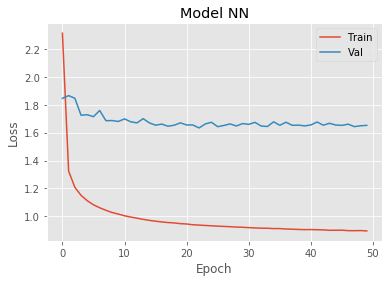

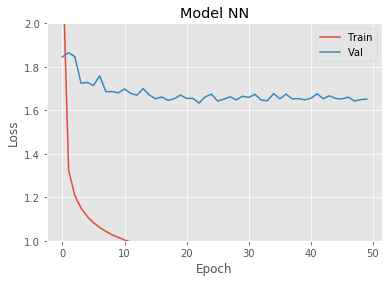

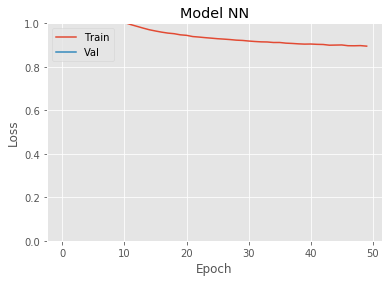

In [0]:
show_plot(hist) 

In [0]:
from keras.models import model_from_json

def load_model(dir = os.getcwd(), name = 'model'):
  json_file = open(os.path.join(dir,name+'.json'), 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = model_from_json(loaded_model_json)
  model.load_weights(os.path.join(dir,name+'.h5'))
  print("Loading is complete.")
  return model

In [0]:
nn = load_model(DIR, 'model_nn')
opt = Adam(lr = 0.05)
nn.compile(optimizer = opt, loss = mse)


In [0]:
X_test.shape

In [0]:
p = nn.predict(X_test, batch_size = 100000)

In [0]:
df_sample_submission.to_csv(DIR+'out_file_int.csv', index = False)

In [0]:
df_sample_submission.head()

,row_id,meter_reading
8784,0,187.721802
8785,129,170.970444
8786,258,158.120926
8787,387,150.405380
8788,516,149.041794


In [0]:
df_sample_submission['row_id'] = df_sample_submission['row_id'].astype('Int32')
df_sample_submission['meter_reading'] = df_sample_submission['meter_reading'].astype('float16')